In [2]:
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as s
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import LineString
import shapely.geometry as geom
import datetime as dt
import csv
import json
pd.set_option("display.max_rows", 20, "display.max_columns", None)

data import

In [3]:
#data directory
datadir = os.path.join(os.path.abspath(''),'data')
outdir = os.path.join(os.path.abspath(''),'out')

#counting data
#nrows limits data amount during code test , nrows=10000
bikped = pd.read_csv(os.path.join(datadir, 'bikped.csv'), encoding = "utf-8", sep=',')
miv = pd.read_csv(os.path.join(datadir, 'miv.csv'), encoding = "utf-8", sep=',')

#id of counting machine irrelevant, drop
bikped=bikped.drop(columns=["FK_ZAEHLER"])

extract and aggregate relevant data bike and pedestrian data

In [21]:
agg=bikped.copy()
agg.shape
#get day as int from datetime (gejson export doesnt accept dt-format) and create attribute that contains "readable" date
agg["DATUM"]=pd.to_datetime(agg["DATUM"])


#readable date
agg["dtstr"] = agg["DATUM"].dt.strftime("%d.%m.%Y")
agg["DATUM"]=agg["DATUM"].dt.isocalendar().week.astype(int)

#create attribute for means of transport: bike and pedestrian
def assignkind(row):
    if pd.isna(row['VELO_IN']) & pd.isna(row['VELO_OUT']):
        val = 1
    elif pd.isna(row['FUSS_IN']) & pd.isna(row['FUSS_OUT']):
        val = 2
    else: 
        val = 0
    return val

agg['kind'] = agg.apply(assignkind, axis=1)
display(agg)

def combloc(row):
    if row['FK_STANDORT']==3277:
        loc = 2989
    elif row['FK_STANDORT']==2976:
        loc = 2977
    elif row['FK_STANDORT']==65:
        loc=2
    elif row['FK_STANDORT']==39:
        loc=296
    else:
        loc = row['FK_STANDORT']
    return loc

agg['FK_STANDORT'] = agg.apply(combloc, axis=1)

#sum counts to kind, location, date, and keep coords and station id
agg = agg.groupby(['FK_STANDORT', 'DATUM', 'kind']).agg(
                bik=('VELO_IN', 'sum'),
                ped=('FUSS_IN', 'sum'),
                dtstr=('dtstr', 'first'),
                lon=('OST', 'first'),
                lat=('NORD', 'first'))

agg['bik']=agg['bik'].astype(int)
agg['ped']=agg['ped'].astype(int)
display(agg)
#reset index
agg['i'] = np.arange(len(agg))
agg = agg.reset_index()
agg.set_index('i')
agg=agg.drop(columns=['i'])

#rename columns
agg=agg.rename(columns={
    "FK_STANDORT" : "loc",
    "DATUM" : "wk",

    })
display(agg)

,FK_STANDORT,DATUM,VELO_IN,VELO_OUT,FUSS_IN,FUSS_OUT,OST,NORD,dtstr,kind
0,3927,1,1.0,1.0,NaN,NaN,2682873,1245891,01.01.2020,2
1,20,1,NaN,NaN,7.0,4.0,2682689,1247735,01.01.2020,1
2,2977,1,1.0,NaN,NaN,NaN,2682681,1250570,01.01.2020,2
3,2976,1,1.0,0.0,NaN,NaN,2682647,1250364,01.01.2020,2
4,2979,1,0.0,0.0,NaN,NaN,2681858,1251991,01.01.2020,2
...,...,...,...,...,...,...,...,...,...,...
1224954,3927,51,0.0,0.0,NaN,NaN,2682873,1245891,14.12.2020,2
1224955,2982,51,1.0,NaN,NaN,NaN,2683447,1247063,14.12.2020,2
1224956,3923,51,2.0,0.0,NaN,NaN,2681385,1247736,14.12.2020,2
1224957,2994,51,NaN,NaN,0.0,0.0,2681402,1253280,14.12.2020,1


bik    ped       dtstr      lon      lat
FK_STANDORT DATUM kind                                           
2           1     1        0   6357  01.01.2020  2679190  1249436
            2     1        0  16390  06.01.2020  2679174  1249438
            3     1        0  17152  13.01.2020  2679190  1249436
            4     1        0  17142  20.01.2020  2679174  1249438
            5     1        0  16995  27.01.2020  2679190  1249436
...                      ...    ...         ...      ...      ...
3927        47    2     5481      0  16.11.2020  2682873  1245891
            48    2     4932      0  23.11.2020  2682873  1245891
            49    2     3370      0  30.11.2020  2682873  1245891
            50    2     3191      0  07.12.2020  2682873  1245891
            51    2      657      0  14.12.2020  2682873  1245891

[1812 rows x 5 columns]

,loc,wk,kind,bik,ped,dtstr,lon,lat
0,2,1,1,0,6357,01.01.2020,2679190,1249436
1,2,2,1,0,16390,06.01.2020,2679174,1249438
2,2,3,1,0,17152,13.01.2020,2679190,1249436
3,2,4,1,0,17142,20.01.2020,2679174,1249438
4,2,5,1,0,16995,27.01.2020,2679190,1249436
...,...,...,...,...,...,...,...,...
1807,3927,47,2,5481,0,16.11.2020,2682873,1245891
1808,3927,48,2,4932,0,23.11.2020,2682873,1245891
1809,3927,49,2,3370,0,30.11.2020,2682873,1245891
1810,3927,50,2,3191,0,07.12.2020,2682873,1245891


In [ ]:
agg

extract and aggregate relevant car data

In [22]:
fulldata =agg.copy()

fulldata = fulldata.groupby(['loc', 'wk', 'kind', 'lon', 'lat']).agg(
                ped=('ped', 'sum'),
                bik=('bik', 'sum'),
                dtstr=('dtstr', 'first'))
fulldata['n']=(fulldata['ped']+fulldata['bik']).astype(int)


#reset index
fulldata['i'] = np.arange(len(fulldata))
fulldata = fulldata.reset_index()
fulldata.set_index('i')
fulldata=fulldata.drop(columns=['i'])

fulldata['lontemp']=fulldata['lat']
fulldata['lat']=fulldata['lon']
fulldata['lon']=fulldata['lontemp']
fulldata=fulldata.drop(columns=['lontemp', 'bik', 'ped'])
fulldata['kind']=fulldata['kind'].astype(int)
display(fulldata)

,loc,wk,kind,lon,lat,dtstr,n
0,2,1,1,1249436,2679190,01.01.2020,6357
1,2,2,1,1249438,2679174,06.01.2020,16390
2,2,3,1,1249436,2679190,13.01.2020,17152
3,2,4,1,1249438,2679174,20.01.2020,17142
4,2,5,1,1249436,2679190,27.01.2020,16995
...,...,...,...,...,...,...,...
1807,3927,47,2,1245891,2682873,16.11.2020,5481
1808,3927,48,2,1245891,2682873,23.11.2020,4932
1809,3927,49,2,1245891,2682873,30.11.2020,3370
1810,3927,50,2,1245891,2682873,07.12.2020,3191


write geojson file

In [25]:
#output geojson file

proctable=fulldata.copy()

zuri = gpd.GeoDataFrame(proctable, geometry=gpd.points_from_xy(proctable.lat, proctable.lon))


zuri = zuri.set_crs(epsg=2056, allow_override=True)
zuri = zuri.to_crs(epsg=4326)

zuri=zuri.drop(columns=["lon","lat"])
display(zuri.crs)
display(zuri)

zuri.to_file(os.path.join(outdir,'zuri.geojson'), driver='GeoJSON')




<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

,loc,wk,kind,dtstr,n,geometry
0,2,1,1,01.01.2020,6357,POINT (8.48750 47.39099)
1,2,2,1,06.01.2020,16390,POINT (8.48729 47.39101)
2,2,3,1,13.01.2020,17152,POINT (8.48750 47.39099)
3,2,4,1,20.01.2020,17142,POINT (8.48729 47.39101)
4,2,5,1,27.01.2020,16995,POINT (8.48750 47.39099)
...,...,...,...,...,...,...
1807,3927,47,2,16.11.2020,5481,POINT (8.53562 47.35866)
1808,3927,48,2,23.11.2020,4932,POINT (8.53562 47.35866)
1809,3927,49,2,30.11.2020,3370,POINT (8.53562 47.35866)
1810,3927,50,2,07.12.2020,3191,POINT (8.53562 47.35866)


statistics for preparing display parameters

In [23]:
fulldata['n'].describe()

count     1812.000000
mean      7811.603201
std       9556.140302
min          0.000000
25%       2372.500000
50%       4819.500000
75%       9597.500000
max      73566.000000
Name: n, dtype: float64

0.1     1234.1
0.2     1955.6
0.3     2777.2
0.4     3845.2
0.5     4819.5
0.6     6275.8
0.7     8527.2
0.8    11144.0
0.9    15821.3
1.0    73566.0
Name: n, dtype: float64

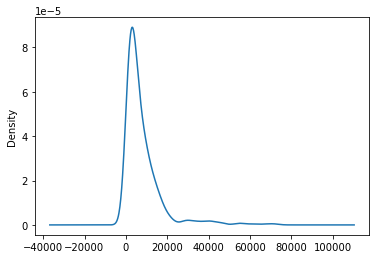

In [24]:
ax = fulldata['n'].plot.kde()

pd.qcut(fulldata['n'], q=8)

fulldata['n'].quantile([.1,.2,.3,.4,.5,.6,.7,.8,.9,1])